In [1]:
import pandas as pd

In [2]:
import os
import sys
dir_path = '/'.join(os.path.realpath('.').split('/')[:-1])
print(dir_path)
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')

import time
import numpy as np
import sglm
import sglm_cv
import sglm_pp
import sglm_ez
import sglm_plt as splt
import sglm_save as ssave
from lynne_pp import *
import pandas as pd
import matplotlib.pyplot as plt


/Users/josh/Documents/Harvard/GLM


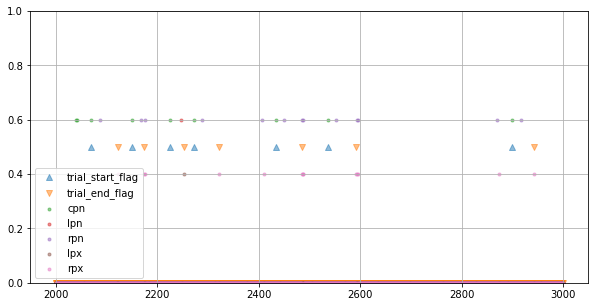

In [3]:
df = pd.read_csv('/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10062021.txt')
df = df[[_ for _ in df.columns if 'Unnamed' not in _]]
df = rename_columns(df)
df = define_trial_starts_ends(df, trial_shift_bounds=0)

lb = 2000
ub = 3000

plt.figure(figsize=(10,5))
care = df.iloc[lb:ub]
for col in ['trial_start_flag', 'trial_end_flag', 'cpn', 'lpn', 'rpn', 'lpx', 'rpx']:
    if col == 'trial_start_flag':
        marker = '^'
        mult = 0.5
    elif col == 'trial_end_flag':
        marker = 'v'
        mult = 0.5
    else:
        marker = '.'
        if col[-1] == 'n':
            mult = 0.6
        else:
            mult = 0.4
    care_filt = care#[care[col] > 0]
    plt.scatter(care_filt.index, care_filt[col]*mult, label=col, alpha=0.5, marker=marker)
plt.ylim(0,1)
plt.grid(True, which='both')
plt.legend()

In [4]:
df_t = pd.read_csv('/Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10062021.txt')
df_t

,hasAllPhotometryData,photometryCenterInIndex,photometryCenterOutIndex,photometrySideInIndex,photometrySideOutIndex,photometryFirstLickIndex,choseLeft,choseRight,leftRewardProb,rightRewardProb,wasRewarded
0,0,0,0,0,0,0,1,0,0.1,0.9,0
1,0,0,0,0,0,0,1,0,0.1,0.9,0
2,0,0,0,0,0,0,1,0,0.1,0.9,0
3,0,0,0,0,0,0,1,0,0.1,0.9,0
4,0,0,0,0,0,0,1,0,0.1,0.9,0
...,...,...,...,...,...,...,...,...,...,...,...
260,1,28386,28387,28404,28444,28408,0,1,0.1,0.9,1
261,1,28544,28545,28561,28588,28564,0,1,0.1,0.9,1
262,1,28714,28715,28729,28758,28736,0,1,0.1,0.9,1
263,1,28810,28811,28828,28864,28832,0,1,0.1,0.9,1


In [5]:
# dftmp = df.copy()
# dftmp.loc[df_t['photometrySideOutIndex'].values].drop(0)

In [6]:
# idx = 1354
# dftmp.loc[idx-10:idx+10]

In [39]:
def generate_Ab_labels(df_t):
    df_t = df_t.copy()
    df_t['prv_choseLeft'] = df_t['choseLeft'].shift(1)
    df_t['prv_choseRight'] = df_t['choseRight'].shift(1)
    df_t['prv_wasRewarded'] = df_t['wasRewarded'].shift(1)

    df_t['label_1Aa'] = df_t['prv_wasRewarded'].astype(bool).fillna(False)
    df_t['label_2AB'] = ((df_t['choseLeft'] == df_t['prv_choseLeft']) & (df_t['choseRight'] == df_t['prv_choseRight'])).astype(bool).fillna(False)
    df_t['label_2Aa'] = df_t['wasRewarded'].astype(bool).fillna(False)

    df_t['label'] = '  '

    df_t.loc[df_t['label_1Aa'], 'label'] = df_t.loc[df_t['label_1Aa'], 'label'].str.slice_replace(0, 1, 'A')
    df_t.loc[~df_t['label_1Aa'], 'label'] = df_t.loc[~df_t['label_1Aa'], 'label'].str.slice_replace(0, 1, 'a')

    df_t.loc[(df_t['label_2AB']&df_t['label_2Aa']), 'label'] = df_t.loc[(df_t['label_2AB']&df_t['label_2Aa']), 'label'].str.slice_replace(1, 2, 'A')
    df_t.loc[(~df_t['label_2AB']&df_t['label_2Aa']), 'label'] = df_t.loc[(~df_t['label_2AB']&df_t['label_2Aa']), 'label'].str.slice_replace(1, 2, 'B')
    df_t.loc[(df_t['label_2AB']&~df_t['label_2Aa']), 'label'] = df_t.loc[(df_t['label_2AB']&~df_t['label_2Aa']), 'label'].str.slice_replace(1, 2, 'a')
    df_t.loc[(~df_t['label_2AB']&~df_t['label_2Aa']), 'label'] = df_t.loc[(~df_t['label_2AB']&~df_t['label_2Aa']), 'label'].str.slice_replace(1, 2, 'b')

    df_t.loc[df_t['prv_wasRewarded'].isna(), 'label'] = np.nan

    return df_t

In [38]:
pd.get_dummies(df_t['label'])

,AA,AB,Aa,Ab,aA,aB,aa,ab
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
260,0,0,0,0,0,1,0,0
261,1,0,0,0,0,0,0,0
262,1,0,0,0,0,0,0,0
263,1,0,0,0,0,0,0,0


In [7]:
col_lst = [
    'photometryCenterInIndex',
    'photometryCenterOutIndex',
    'photometrySideInIndex',
    'photometrySideOutIndex',
    'photometryFirstLickIndex'
]

In [50]:
import glob

data_folder = '/Users/josh/Documents/Harvard/GLM'

df2 = pd.DataFrame()

basis_Aa_cols = ['AA', 'Aa', 'aA', 'aa', 'AB', 'Ab', 'aB', 'ab']

# GLM_SIGNALS_WT61_10062021.txt

for fn in glob.glob(f'{data_folder}/GLM_SIGNALS_WT61_*.txt'):
    table_fn = fn.replace('GLM_SIGNALS', 'GLM_TABLE')
    print(fn, '--', table_fn)

    df_t = pd.read_csv(table_fn)
    df_t = generate_Ab_labels(df_t)
    ab_dummies = pd.get_dummies(df_t['label'])
    for basis_col in basis_Aa_cols:
        if basis_col not in ab_dummies.columns:
            df_t[basis_col] = 0
    df_t[ab_dummies.columns] = ab_dummies

    # display(df_t)

    df = pd.read_csv(fn)    
    df = df[[_ for _ in df.columns if 'Unnamed' not in _]]

    df = preprocess_lynne(df, trial_shift_bounds=0)

    for col in df_t.columns:
        if 'Index' not in col:
            continue
        print(col)
        df_t_tmp = df_t[(df_t['hasAllPhotometryData'] > 0)&(df_t[col] > 0)].copy()
        df_t_tmp[col] = df_t_tmp[col] - 1
        # display(df_t_tmp.set_index(col)[['wasRewarded']])
        # display(df.columns)

        # df[col] = df_t_tmp.set_index(col)['wasRewarded']

        num_inx_vals = df_t_tmp.groupby(col)['hasAllPhotometryData'].count()
        dupe_inx_vals = num_inx_vals[num_inx_vals > 1].index

        # if len(dupe_inx_vals) > 0:
        #     display(df_t_tmp[df_t_tmp['photometryCenterOutIndex'].isin(dupe_inx_vals)])

        single_inx_vals = num_inx_vals[num_inx_vals == 1].index

        # df[col] = df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)['wasRewarded']
        df[col] = (df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)['wasRewarded'] == df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)['wasRewarded'])*1
        # df[f'{col}_r'] = df[col]
        # df[f'{col}_nr'] = (1 - df[col])
        for basis in ['AA', 'Aa', 'aA', 'aa', 'AB', 'Ab', 'aB', 'ab']:
            df[col+basis] = df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)[basis]


        # if 'Side' in col:
        #     print(f'reward doesnt equal {col}')
        #     display(df[(df['nr'] == df['r'])&(df['nr'] == 1)])
        #     display(df[(df['r'] == df['r'])&(df[col] == df[col])&(df[col] == 1)])

    df['nTrial2'] = (((~df['photometryCenterInIndex'].isna())&(df['photometryCenterInIndex']==1))*1).cumsum()
    df['nEndTrial2'] = (((~df['photometrySideOutIndex'].isna())&(df['photometrySideOutIndex']==1))*1).cumsum()



    # print(df2.isna().sum().sum())

    if len(df2) == 0:
        df2 = df.copy()
    else:
        df2 = df2.append(df)

    # display(df2)
    # break

/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10152021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10152021.txt
Percent of Data in ITI: 0.5209486722342123
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
photometrySideOutIndex
photometryFirstLickIndex
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10042021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10042021.txt
Percent of Data in ITI: 0.5350604796971579
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
photometrySideOutIndex
photometryFirstLickIndex
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10062021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10062021.txt
Percent of Data in ITI: 0.5380593677983009
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
photometrySideOutIndex
photometryFirstLickIndex
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10132021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10132021.tx

In [56]:
df[['nTrial2', 'nEndTrial2']].query("nTrial2 != nEndTrial2")

,nTrial2,nEndTrial2
1210,1,0
1211,1,0
1212,1,0
1213,1,0
1214,1,0
...,...,...
36676,360,359
36677,360,359
36678,360,359
36679,360,359


In [48]:
# df2.iloc[1200:1245][['ft_r_spn', 'ft_nr_spn', 'nn', 'spn', 'spx', 'cpn', 'cpx', 'nTrial', 'nTrial2', 'photometryCenterInIndex']]

In [10]:
df_examine = df2[df2['photometrySideInIndex'].isna()]
df_examine = df_examine[(df_examine['ft_r_spn'] + df_examine['ft_nr_spn'] > 0)&(df_examine['nTrial'] > 0)&(df_examine['nTrial2'] > 0)&(df_examine['nTrial'] > 0)]
# with pd.option_context('max_rows', 3000):
#     display(df_examine[['ft_r_spn', 'ft_nr_spn', 'photometrySideInIndex']])

In [11]:
# glob.glob(f'{data_folder}/GLM_SIGNALS_WT61_*.txt')

In [12]:
df2

,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr,photometryFirstLickIndex,photometryFirstLickIndex_r,photometryFirstLickIndex_nr,nTrial2,nEndTrial2
0,0.555517,-0.207614,0.720531,-0.801691,0.452445,-1.159573,-0.603638,0.526995,0.452445,-1.159573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0.821058,-1.212011,0.128694,0.700425,0.479802,0.440579,-1.458203,0.118326,0.479802,0.440579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,0.895495,-1.309689,0.399287,-0.639261,0.427776,0.009070,-0.136884,0.645182,0.427776,0.009070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,0.369373,0.235882,-0.657023,1.163822,1.076511,-2.299252,0.615730,1.835773,1.076511,-2.299252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,0.633833,0.080268,-0.220334,2.294948,2.274924,-1.121843,0.704893,0.508825,2.274924,-1.121843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37012,2.562576,-1.677753,1.878167,0.133261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,251
37013,4.246441,-0.236823,4.886373,-0.874492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,251
37014,4.408608,-0.663953,4.798602,-0.210249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,251
37015,2.364343,0.720721,2.718583,1.764168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,251


In [13]:
# import glob
# from collections import defaultdict

# fn = glob.glob(f'{data_folder}/GLM_SIGNALS_WT61_10152021.txt')[0]
# table_fn = fn.replace('GLM_SIGNALS', 'GLM_TABLE')
# print(fn, '--', table_fn)

# df_t = pd.read_csv(table_fn)

# df = pd.read_csv(fn)
# df = df[[_ for _ in df.columns if 'Unnamed' not in _]]


# for col in df_t.columns:
#     if 'Index' not in col:
#         continue
#     print(col)
#     df_t_tmp = df_t[(df_t['hasAllPhotometryData'] > 0)&(df_t[col] > 0)].copy()
#     df_t_tmp[col] = df_t_tmp[col] - 1
#     # display(df_t_tmp.set_index(col)[['wasRewarded']])
#     # display(df.columns)

#     # df[col] = df_t_tmp.set_index(col)['wasRewarded']

#     num_inx_vals = df_t_tmp.groupby(col)['hasAllPhotometryData'].count()
#     dupe_inx_vals = num_inx_vals[num_inx_vals > 1].index
#     display(df_t_tmp[df_t_tmp['photometryCenterOutIndex'].isin(dupe_inx_vals)])

#     single_inx_vals = num_inx_vals[num_inx_vals == 1].index

#     df[col] = df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)['wasRewarded']

# df['nTrial'] = ((~df['photometryCenterInIndex'].isna())*1).cumsum()
# df['nEndTrial'] = ((~df['photometrySideOutIndex'].isna())*1).cumsum()


In [14]:
# for col_val in col_lst:
#     # new_name = col_val.replace('Index', '')
#     # df2[f'{new_name}_r'] = df2[new_name]*df2['combor']
#     # df2[f'{new_name}_nr'] = df2[new_name]*(1-df2['combor'])

#     # df2[f'{new_name}_r'] = df2[new_name]*df2['reward']
#     # df2[f'{new_name}_nr'] = df2[new_name]*(1-df2['reward'])

#     # df2[f'{new_name}_r'] = df2[new_name]*df2['wasRewarded']
#     # df2[f'{new_name}_nr'] = df2[new_name]*(1-df2['wasRewarded'])

#     df2[f'{col_val}_r'] = df2[col_val]
#     df2[f'{col_val}_nr'] = (1 - df2[col_val])


In [15]:
# df2

In [16]:
# df2

In [17]:
# lb = 10530
# ub = 10600

# lb, ub = df2['wasRewarded'].iloc[lb:ub].dropna().index.min(), df2['wasRewarded'].iloc[lb:ub].dropna().index.max()

# # inx = df2.iloc[lb:ub].query("(wasRewarded != reward)&(wasRewarded == wasRewarded)&(reward == reward)")['wasRewarded'].dropna().index
# inx = df2.iloc[lb:ub].query("(wasRewarded == wasRewarded)&(reward == reward)")['wasRewarded'].dropna().index
# print(inx)

# # plt.scatter(data=df2['photometrySideIn'].iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn', label='photometrySideIn')
# # plt.scatter(data=(df2['photometrySideIn_r']*2).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_r', label='photometrySideIn_r')
# # plt.scatter(data=(df2['photometrySideIn_nr']*0.5).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_nr', label='photometrySideIn_nr')
# # plt.scatter(data=(df2['wasRewarded']*3).iloc[lb:ub].reset_index(), x='index', y='wasRewarded', label='wasRewarded')
# # plt.scatter(data=(df2['reward']*4).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='reward', label='reward')
# # # plt.scatter(data=(df2['combor']*5).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='combor', label='combor')

# plt.scatter(data=df2.loc[inx,'photometrySideIn'].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn', label='photometrySideIn')
# plt.scatter(data=(df2.loc[inx,'photometrySideIn_r']*2).replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_r', label='photometrySideIn_r')
# plt.scatter(data=(df2.loc[inx,'photometrySideIn_nr']*0.5).replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_nr', label='photometrySideIn_nr')
# plt.scatter(data=(df2.loc[inx,'wasRewarded']*3).reset_index(), x='index', y='wasRewarded', label='wasRewarded')
# plt.scatter(data=(df2.loc[inx,'reward']*4).reset_index(), x='index', y='reward', label='reward')

# plt.legend()
# plt.grid()

In [18]:
df_t[df_t['photometrySideInIndex'].between(10530, 10600)]

,hasAllPhotometryData,photometryCenterInIndex,photometryCenterOutIndex,photometrySideInIndex,photometrySideOutIndex,photometryFirstLickIndex,choseLeft,choseRight,leftRewardProb,rightRewardProb,wasRewarded
88,1,10575,10576,10593,10626,10595,1,0,0.85,0.15,1


In [19]:
# with pd.option_context('max_rows', 1000, 'max_columns', 1000):
#     display(df[df.reset_index()['index'].between(10530, 10600)])

In [20]:
# # df2.columns

# for col in ['photometryCenterInIndex',
#             'photometryCenterOutIndex',
#             'photometrySideInIndex',
#             'photometrySideOutIndex',
#             'photometryFirstLickIndex',
#             'wasRewarded']:
#     df2[col] = 0
#     inx = df_t[col].values - 1
#     inx = inx[inx >= 0]
#     df2.loc[inx, col] = 1

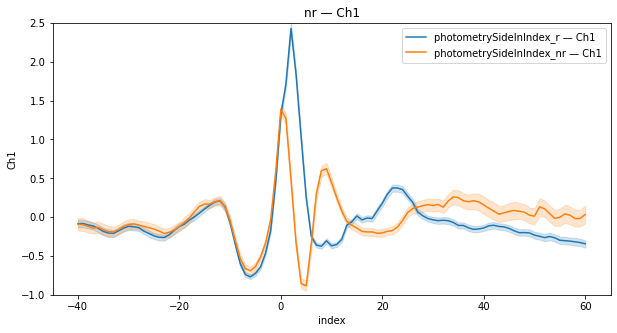

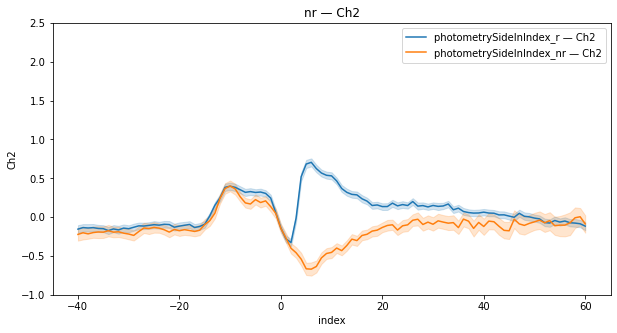

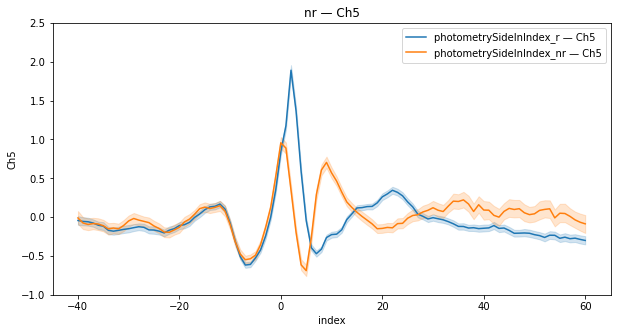

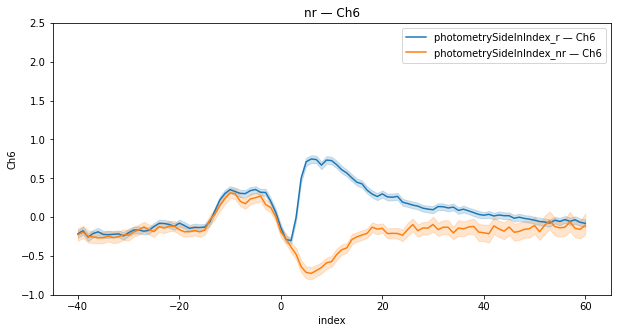

,index,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,...,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr,photometryFirstLickIndex,photometryFirstLickIndex_r,photometryFirstLickIndex_nr,nTrial2,nEndTrial2
0,-39,-0.136362,-0.476137,1.301458,0.337818,1.428950,-1.627329,0.492389,0.672019,1.428950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
1,-38,-0.907460,-1.315439,-0.516549,2.141083,1.703498,-0.278618,0.742558,-1.055320,1.703498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
2,-37,-0.898595,-0.299240,-0.717288,0.404904,2.017149,-0.387965,0.902745,-2.236229,2.017149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
3,-36,-0.383572,-0.792115,-1.066205,-0.663304,1.574256,0.259020,-0.363655,-1.245164,1.574256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
4,-35,0.287747,-1.138632,0.435323,0.156124,1.152354,-1.271957,-0.055872,-1.372935,1.152354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,35,0.483259,-0.342548,0.061317,0.815913,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,245
287,36,0.331137,-0.060428,0.718842,0.411951,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,245
288,37,-0.011928,0.936727,-0.188026,0.812420,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,245
289,38,0.274300,1.407852,-0.595536,0.116283,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245,245


In [21]:
import seaborn as sns
from tqdm.notebook import tqdm

for channel in ['Ch1', 'Ch2', 'Ch5', 'Ch6']:
    plt.figure(figsize=(10,5))
    for alignment_col in ['photometrySideInIndex_r', 'photometrySideInIndex_nr']:
        relative_df = pd.DataFrame()
        
        rel_points = df2[df2[alignment_col] > 0].reset_index()
        identifiers = rel_points[['index', 'nTrial', 'nEndTrial']].dropna().values.astype(int)
        
        lst_extendeds = []
        
        for idx, nTrial, nEndTrial in tqdm(identifiers):
            extended_trial = df2[(df2['nTrial'] == nTrial) | (df2['nEndTrial'] == nEndTrial)].reset_index().copy()
            extended_trial['index'] -= idx

            lst_extendeds.append(extended_trial.copy())
            
        relative_df = pd.concat(lst_extendeds)

        
        alignment_name = alignment_col.split('_')[-1]
        sns.lineplot(x='index', y=channel, data=relative_df[relative_df['index'].between(-40, 60)], label=f'{alignment_col} — {channel}')
        
        plt.title(f'{alignment_name} — {channel}')
        plt.ylim(-1,2.5)
        plt.grid()
        
    plt.legend()
    plt.show()

display(relative_df)


In [22]:
print(plot_df)

NameError: name 'plot_df' is not defined